# Домашняя работа №4
# Студент: Правилов Михаил

# Задание 1

"Напишите программу вычисляющую корни полиномов Лежандра, используя любой из методов с лекции, кроме половинного деления. Используйте для вычисления значений полиномов scipy.special.legendre и перемежаемость корней полномов послежовательных степеней."

Я предлагаю использовать итеративный метод Ньютона, так как производная выражается через сами полиномы, а также этот метод довольно-таки прост в реализации.

Полиномы будем считать с помощью рекуррентной формулы.

Выпишем формулы:

$P_{n + 1}(x) = \frac{2n + 1}{n + 1}xP_n(x) - \frac{n}{n + 1}P_{n - 1}(x)$,

$P_0(x) = 1, P_1(x) = x$

$P'_n(x) = \frac{n}{1 - x^2} * [P_{n - 1}(x) - xP_n(x)]$

$x_i^{(k + 1)} = x_i^{(k)} - \frac{P_n(x_i^{(k)})}{P'_n(x_i^{(k)})}$ шаг в метода Ньютона для вычисления i-го корня.

$x_i^{(0)} = cos[\pi(4i - 1) / (4n + 2)]$ начальная точка для поиска i-го корня. Здесь мы как раз пользуемся перемежаемостью, у нас $x_i^{(0)}$ будет лежать между корнями (или корнем и +-1) многочлена на одну степень ниже.

Корней как известно $n$ => $i = 1..n$

Также можно воспользоваться перемежаемость в лоб. Давайте просто брать $a_i^{n} = \frac{a_{i - 1}^{n - 1} + a_{i}^{n - 1}}{2}$, где $a_i^n$ - это начальная точка поиска i-го корня n-го полинома Лежандра. Вообще считаться корни будут подольше. Я остановился на этом варианте, потому что предыдущий с косинусами не доказывал.

По поводу количества итераций: попробовал разные значения, 10 дает хороший результат.

In [256]:
from scipy.special import legendre

def get_legendre_derivative(n):
    def derivative(x):
        P_n_1 = legendre(n - 1)
        P_n = legendre(n)
        return n / (1 - x ** 2) * (P_n_1(x) - x * P_n(x))
    return derivative

def calculate_legendre_i_root_cos(n, i):
    number_of_iterations = 10
    x_cur = np.cos(np.pi * (4 * i - 1) / (4 * n + 2))
    P_n = legendre(n)
    P_n_derivative = get_legendre_derivative(n)
    for k in range(number_of_iterations):
        x_cur = x_cur - P_n(x_cur) / P_n_derivative(x_cur)
    return x_cur

def calculate_legendre_i_root_interlacing(n, i):
    number_of_iterations = 10
    left_root = None
    right_root = None
    if n == 1:
        return 0
    if i == 1:
        left_root = -1
    else:
        left_root = calculate_legendre_i_root_interlacing(n - 1, i - 1)
    if i == n:
        right_root = 1
    else:
        right_root = calculate_legendre_i_root_interlacing(n - 1, i)
    x_cur = (left_root + right_root) / 2
    P_n = legendre(n)
    P_n_derivative = get_legendre_derivative(n)
    for k in range(number_of_iterations):
        x_cur = x_cur - P_n(x_cur) / P_n_derivative(x_cur)
    return x_cur

def calculate_legendre_roots(n, calculate_legendre_i_root=calculate_legendre_i_root_interlacing):
    return [calculate_legendre_i_root(n, i) for i in range(1, n + 1)]

In [257]:
n = 5
roots = calculate_legendre_roots(n)
numpy_roots = np.polynomial.legendre.leggauss(n)[0]
print("Legendre polynomial roots for n = " + str(n))
print("my implementation: " + str(roots))
print("numpy implementation: " + str(numpy_roots))

Legendre polynomial roots for n = 5
my implementation: [-0.9061798459386641, -0.5384693101056831, 8.08634922390439e-174, 0.5384693101056831, 0.906179845938664]
numpy implementation: [-0.90617985 -0.53846931  0.          0.53846931  0.90617985]


"Найдите веса соответствуюей формулы Гаусса, используя написанную ранее программу"

Мы знаем с лекции, что $w_i = \int_{a}^{b}{\prod_{k \neq i}{\frac{x - x_k}{x_i - x_k}}\rho(x) dx}$

Для полиномов Лежандра $\alpha = \beta = 0$, поэтому $\rho(x) = 1$ (было на лекции).

Также из предыдущего дз возьмем метод Симпсона. С помощью него и будем считать интеграл для весов. M = 1000 возьмем, где M количество интервалов для метода Сипмсона. Как показало предыдущее дз 1000 будет более чем достаточно.

In [258]:
def calculate_Simpson(f, a, b, M):
    H = (b - a) / M
    res = f(a) + f(b) + 4 * f(a + H / 2)
    x_cur = a + H
    for i in range(1, M):
        res += 2 * f(x_cur) + 4 * f(x_cur + H / 2)
        x_cur += H
    res *= H / 6
    return res

def get_weights(a, b, xs, calculation_method=calculate_Simpson, M=1000):
    N = len(xs)
    def f_to_integrate(i):
        def f(x):
            prod = 1
            for k in range(0, N):
                if k != i:
                    x_k = xs[k]
                    x_i = xs[i]
                    prod *= (x - x_k) / (x_i - x_k)
            return prod
        return f
    
    weights = []
    for i in range(0, N):
        weight = calculation_method(f_to_integrate(i), a, b, M)
        weights.append(weight)
    return weights

def get_weights_legendre_specific(xs):
    P_n_derivative = get_legendre_derivative(n)
    return [2 / ((1 - xs[i] ** 2) * P_n_derivative(xs[i]) ** 2) for i in range(0, len(xs))]

def get_weights_for_legendre(n, calculate_legendre_i_root=calculate_legendre_i_root_interlacing):
    roots = calculate_legendre_roots(n, calculate_legendre_i_root)
    return get_weights(-1, 1, roots)

In [259]:
n = 5
weights = get_weights_for_legendre(n)
numpy_weights = np.polynomial.legendre.leggauss(n)[1]
print("Legendre polynomial weights for n = " + str(n))
print("my implementation: " + str(weights))
print("numpy implementation: " + str(numpy_weights))

Legendre polynomial weights for n = 5
my implementation: [0.23692688505649478, 0.47862867049849994, 0.5688888888900089, 0.4786286704984987, 0.23692688505649706]
numpy implementation: [0.23692689 0.47862867 0.56888889 0.47862867 0.23692689]


Вспомним наше реальное значение интеграла $\int_{-1}^{5}{\frac{1}{1 + 9x^2} dx} = 1 / 3 * arctg(3x) |_{-1}^{5} \approx 0.917757978$

"Напишите программу вычисляющую I  с помощью полученной квадратурной формулы"

In [260]:
a = -1
b = 5

def f(x):
    return 1 / (1 + 9 * x ** 2)

def antiderivative(x):
    return 1 / 3 * np.arctan(3 * x)

a = -1
b = 5
length = b - a
real_value = antiderivative(b) - antiderivative(a)

In [264]:
def calculate_integral_legendre(f, a, b, n, calculate_i_root=calculate_legendre_i_root_interlacing):
    roots = calculate_legendre_roots(n, calculate_i_root)
    weights = get_weights_for_legendre(n, calculate_i_root)
    f_values = [f((b - a) / 2 * roots[i] + (b + a) / 2) for i in range(len(roots))]
    return (b - a) / 2 * np.dot(weights, f_values)

In [262]:
def draw_error_integral(f, a, b, real_value, calculation_method, N_min, N_max):
    data_x = []
    data_y = []
    N_cur = N_min
    step = 1
    while N_cur <= N_max:
        approx = calculation_method(f, a, b, N_cur)
        data_x.append(N_cur)
        data_y.append(np.log10(abs(approx - real_value)))
        N_cur += step
    plt.subplot(211)
    plt.plot(data_x, data_y)
    plt.ylabel("log10(|integral_real - approx_value|)")
    plt.xlabel("N")

/home/mikhail/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


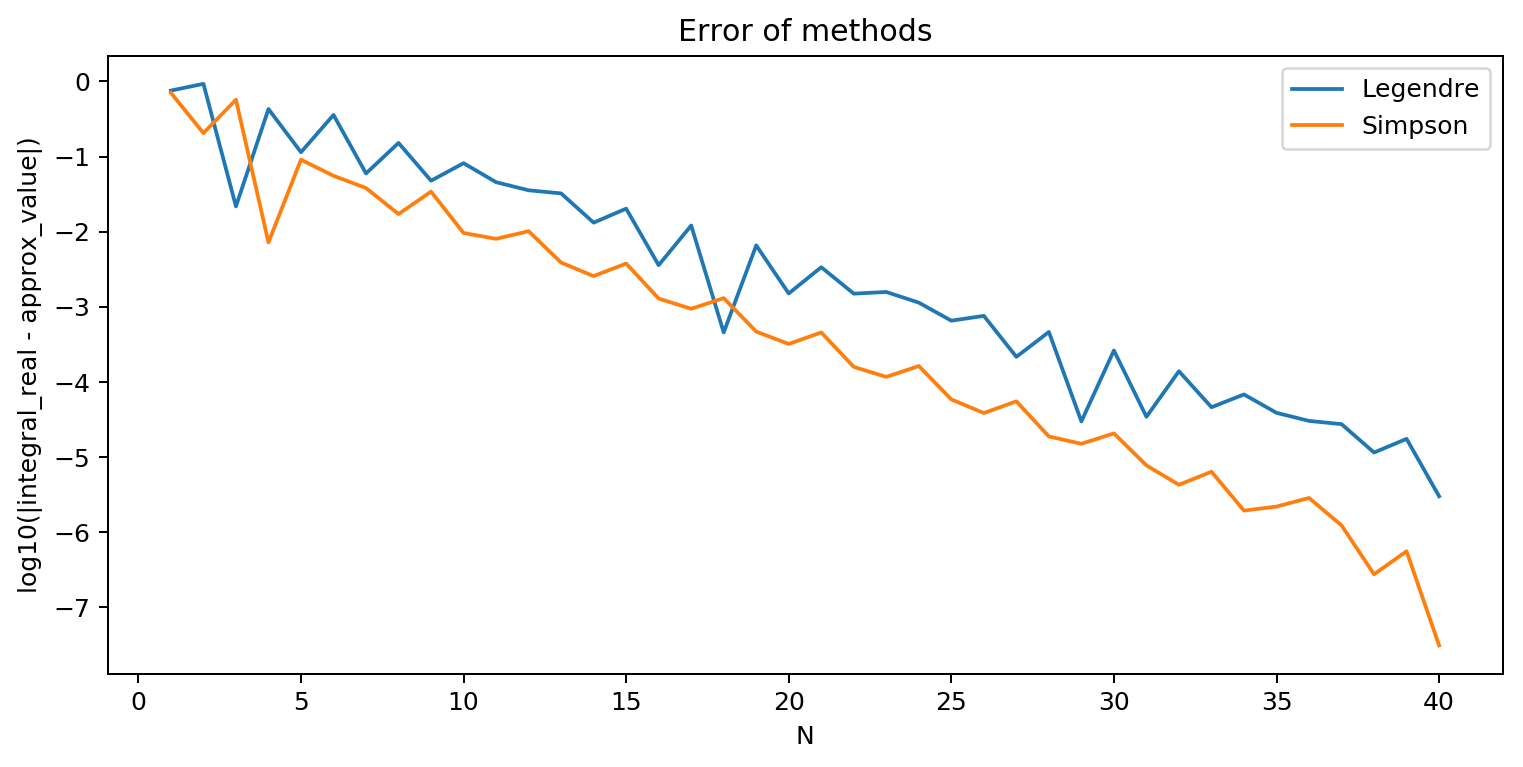

In [263]:
plt.figure(figsize=(10, 10), dpi=180)
draw_error_integral(f, a, b, real_value, calculate_integral_legendre, 1, 40)
draw_error_integral(f, a, b, real_value, calculate_Simpson, 1, 40)
plt.title("Error of methods")
plt.legend(("Legendre", "Simpson"))
plt.show()

Графики скачут постоянно, и Симпсон лучше. Если не учитывать скачки, это похоже на прямую. А значит, раз это график в координатах $(log10(err(x)); x)$, то прямая означает, что погрешность убывает экспоненциально. 